In [1]:
!pip install tensorflow==2.13.0 mediapipe opencv-python matplotlib

In [2]:
import cv2
import numpy as np
import os, glob
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# Dataset Load

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile
import os

# Path to the zip file in Drive
zip_path = "/content/drive/MyDrive/ModelTrain/signlanguage/dataset/DS.zip"

# Unzip it to /content/
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/dS")

# Set dataset path
dataset_path = "/content/dS"

# Key Points of MP Holistic

In [5]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [6]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [7]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [8]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             )
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             )
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             )
    # Draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )

In [9]:
def extract_keypoints(results, image_hight, image_width):
    if results.pose_landmarks:
        land_marks = [results.pose_landmarks.landmark[mp_holistic.PoseLandmark.NOSE], results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_SHOULDER], results.pose_landmarks.landmark[mp_holistic.PoseLandmark.RIGHT_SHOULDER], results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_ELBOW],  results.pose_landmarks.landmark[mp_holistic.PoseLandmark.RIGHT_ELBOW],  results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_WRIST],  results.pose_landmarks.landmark[mp_holistic.PoseLandmark.RIGHT_WRIST],  results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_PINKY],  results.pose_landmarks.landmark[mp_holistic.PoseLandmark.RIGHT_PINKY],  results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_INDEX],  results.pose_landmarks.landmark[mp_holistic.PoseLandmark.RIGHT_INDEX],  results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_THUMB],  results.pose_landmarks.landmark[mp_holistic.PoseLandmark.RIGHT_THUMB]]
        x_1 = results.pose_landmarks.landmark[mp_holistic.PoseLandmark.NOSE].x * image_width
        y_1 = results.pose_landmarks.landmark[mp_holistic.PoseLandmark.NOSE].y * image_hight
    else:
        np.zeros(13*2)
    pose = np.array([[(res.x * image_width)-x_1, (res.y * image_hight)-y_1] for res in land_marks]).flatten() if results.pose_landmarks else np.zeros(13*2)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])
    #return np.concatenate([lh, rh])
    #return pose

In [10]:
lebels = ['Bird', 'Bitter', 'Black', 'Book', 'Bread', 'Break', 'Caram', 'Chair', 'Clean', 'Come', 'Degrade', 'Door', 'Egg', 'Exercise', 'Exercise Book', 'Fate', 'February', 'Fish', 'Food', 'Good', 'Goodboy', 'Growth', 'Hearing_Impaired', 'January', 'Khoda Hafez', 'Large', 'Listen', 'March', 'Me', 'Meat', 'Mobile', 'More', 'Pencil', 'Picture', 'Procession', 'Quick', 'Remember', 'Rose Color', 'Salam', 'Short', 'Sit', 'Small', 'Snake', 'Table', 'Telephone', 'Thanks', 'Tiger', 'Together', 'Up', 'Wet']

lebels =  ['A lot', 'All of you', 'Another']

print(len(lebels))
classes = np.array(lebels)
print(classes)
label_map = {label:num for num, label in enumerate(lebels)}

print(label_map)

3
['A lot' 'All of you' 'Another']
{'A lot': 0, 'All of you': 1, 'Another': 2}


In [11]:
####################### pre-processing #############################################
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


import glob
import os
import os.path
import numpy as np


#DATA_PATH = os.path.join('DataSet-50')
DATA_PATH = os.path.join('tem')
sequence_length = 30

#lebels = ['bird']
#lebels = ['Bird', 'Bitter','Black','Book']


label_map = {label:num for num, label in enumerate(lebels)}

print(label_map)


def get_video_parts(video_path):
    """Given a full path to a video, return its parts."""
    parts = video_path.split(os.path.sep)
    filename = parts[2]
    filename_no_ext = filename.split('.')[0]
    classname = parts[1]
    train_or_test = parts[0]

    return train_or_test, classname, filename_no_ext, filename

{'A lot': 0, 'All of you': 1, 'Another': 2}


In [12]:
def get_video_parts(video_path):
    """Given a full path to a video, return its parts."""
    parts = video_path.split(os.path.sep)
    filename = parts[2]
    filename_no_ext = filename.split('.')[0]
    classname = parts[1]
    train_or_test = parts[0]

    return train_or_test, classname, filename_no_ext, filename


#np.load('0.npy')

#DATA_PATH = os.path.join('DataSet-50')
DATA_PATH = os.path.join('/content/dS/DS')

data_file = []

sequence_length = 30
sequence = 0
s = 0
i = 0
j = 0


In [13]:
import cv2
import numpy as np
import os, glob
from matplotlib import pyplot as plt
import time
import mediapipe as mp
# from google.colab.patches import cv2_imshow # Removed cv2_imshow import as it's not needed
for vid_class in classes:
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        class_files = glob.glob(os.path.join(DATA_PATH, vid_class, '*.mp4'))
        i += 1

        for video_path in class_files:
            j += 1
            cap = cv2.VideoCapture(video_path)
            length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            sequence += 1

            print(f"Processing {video_path} ... total frames = {length}")

            for frame_num in range(length):
                ret, frame = cap.read()
                if not ret:
                    print("Frame read failed, skipping rest.")
                    break

                image_height, image_width, _ = frame.shape

                image, results = mediapipe_detection(frame, holistic)

                # Extract keypoints
                keypoints = extract_keypoints(results, image_height, image_width)

                # Save npy
                class_save_dir = os.path.join(DATA_PATH, vid_class, os.path.splitext(os.path.basename(video_path))[0])
                if not os.path.exists(class_save_dir):
                    os.makedirs(class_save_dir)

                npy_path = os.path.join(class_save_dir, str(frame_num))
                np.save(npy_path, keypoints)

                s += 1

            cap.release()

print("All Done!")

Processing /content/dS/DS/A lot/s_52_w_113_a_30.mp4 ... total frames = 55
Processing /content/dS/DS/A lot/s_54_w_113_a_30.mp4 ... total frames = 49
Processing /content/dS/DS/A lot/s_55_w_113_a_30.mp4 ... total frames = 53
Processing /content/dS/DS/A lot/s_56_w_113_a_30.mp4 ... total frames = 58
Processing /content/dS/DS/A lot/s_40_w_113_a_30.mp4 ... total frames = 49
Processing /content/dS/DS/A lot/s_11_w_113_a_30.mp4 ... total frames = 48
Processing /content/dS/DS/A lot/s_34_w_113_a_30.mp4 ... total frames = 53
Processing /content/dS/DS/A lot/s_47_w_113_a_30.mp4 ... total frames = 71
Processing /content/dS/DS/A lot/s_14_w_113_a_30.mp4 ... total frames = 42
Processing /content/dS/DS/A lot/s_41_w_113_a_30.mp4 ... total frames = 64
Processing /content/dS/DS/A lot/s_53_w_113_a_30.mp4 ... total frames = 72
Processing /content/dS/DS/All of you/s_40_w_104_a_30.mp4 ... total frames = 55
Processing /content/dS/DS/All of you/s_34_w_104_a_30.mp4 ... total frames = 53
Processing /content/dS/DS/Al

In [14]:
import os
import glob
import numpy as np
from tensorflow.keras.utils import to_categorical

sequence_length = 30
step_size = 5

sequences = []
labels = []

for label_name in lebels:
    # Get all subfolders inside class folder (each subfolder corresponds to a video)
    video_folders = [f for f in glob.glob(os.path.join(DATA_PATH, label_name, '*')) if os.path.isdir(f)]

    for video_folder in video_folders:
        # Only load .npy files, ignore any .mp4 files
        npy_files = sorted(glob.glob(os.path.join(video_folder, '*.npy')))
        total_frames = len(npy_files)

        if total_frames < sequence_length:
            print(f"Skipping {video_folder}, not enough frames ({total_frames})")
            continue

        print(f"\nVideo: {video_folder} | total frames: {total_frames}")

        # Create sequences folder inside this video folder
        seq_save_dir = os.path.join(video_folder, 'sequences')
        if not os.path.exists(seq_save_dir):
            os.makedirs(seq_save_dir)
            print(f"Created folder: {seq_save_dir}")
        else:
            print(f"Folder already exists: {seq_save_dir}")

        # Sliding window to generate sequences
        seq_index = 0
        for start in range(0, total_frames - sequence_length + 1, step_size):
            window = []
            for frame_num in range(start, start + sequence_length):
                keypoints = np.load(npy_files[frame_num])
                window.append(keypoints)

            sequences.append(window)
            labels.append(label_map[label_name])

            # Save sequence as .npy file inside sequences folder
            np.save(os.path.join(seq_save_dir, f"seq_{seq_index}.npy"), np.array(window))
            seq_index += 1

        # Print how many sequences were created for this video
        print(f"Total sequences generated for {video_folder}: {seq_index}")

# Convert all sequences to numpy arrays for model input
X = np.array(sequences)
y = to_categorical(labels).astype(int)

print("\nFinal X shape:", X.shape)
print("Final y shape:", y.shape)



Video: /content/dS/DS/A lot/s_56_w_113_a_30 | total frames: 58
Created folder: /content/dS/DS/A lot/s_56_w_113_a_30/sequences
Total sequences generated for /content/dS/DS/A lot/s_56_w_113_a_30: 6

Video: /content/dS/DS/A lot/s_55_w_113_a_30 | total frames: 53
Created folder: /content/dS/DS/A lot/s_55_w_113_a_30/sequences
Total sequences generated for /content/dS/DS/A lot/s_55_w_113_a_30: 5

Video: /content/dS/DS/A lot/s_40_w_113_a_30 | total frames: 49
Created folder: /content/dS/DS/A lot/s_40_w_113_a_30/sequences
Total sequences generated for /content/dS/DS/A lot/s_40_w_113_a_30: 4

Video: /content/dS/DS/A lot/s_14_w_113_a_30 | total frames: 42
Created folder: /content/dS/DS/A lot/s_14_w_113_a_30/sequences
Total sequences generated for /content/dS/DS/A lot/s_14_w_113_a_30: 3

Video: /content/dS/DS/A lot/s_41_w_113_a_30 | total frames: 64
Created folder: /content/dS/DS/A lot/s_41_w_113_a_30/sequences
Total sequences generated for /content/dS/DS/A lot/s_41_w_113_a_30: 7

Video: /conten

In [15]:
import numpy as np
from tensorflow.keras import Input, optimizers, callbacks
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical # Although y is already one-hot encoded, import is useful


def build_lstm_model(input_shape, num_classes):
    """Builds a simple stacked LSTM model."""
    model_input = Input(shape=input_shape)
    x = LSTM(128, return_sequences=True, activation='relu')(model_input)
    x = LSTM(64, activation='relu')(x) # return_sequences=False by default
    x = Dense(64, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(model_input, x)
    return model

# Check if X and y are available
if 'X' in locals() and 'y' in locals():
    print(f"Using X with shape: {X.shape} and y with shape: {y.shape}")

    # Define input shape and number of classes
    input_shape = (X.shape[1], X.shape[2])
    num_classes = y.shape[1]

    # Build the model
    model = build_lstm_model(input_shape, num_classes)

    # Compile the model
    rms = optimizers.RMSprop(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=rms, metrics=['accuracy'])

    model.summary()

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

    print("\nShape of X_train:", X_train.shape)
    print("Shape of y_train:", y_train.shape)
    print("Shape of X_test:", X_test.shape)
    print("Shape of y_test:", y_test.shape)


    # Define callbacks
    c_backs = [callbacks.EarlyStopping(patience=40, restore_best_weights=True)]

    # Train the model
    print("\nStarting model training...")
    history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=100, # Set a reasonable number of epochs, EarlyStopping will stop training
                        callbacks=c_backs)

    print("\nModel training finished.")

    # Save the model
    model.save('lstm_bsl_model.h5')
    print("Model saved as lstm_bsl_model.h5")

else:
    print("X or y variables not found. Please ensure they are defined in previous cells.")

Using X with shape: (217, 30, 1556) and y with shape: (217, 3)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 1556)]        0         
                                                                 
 lstm (LSTM)                 (None, 30, 128)           862720    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 916483 (3.50 MB)
Trainable params: 916483 (3.50 MB)
Non-trainable params: 0 (0.00 Byte)
____________________________

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model loaded successfully.

Test data found. Evaluating the model...

Model Accuracy: 63.64%
2/2 [==============================] - 0s 18ms/step

Confusion Matrix:
[[ 5  4  1]
 [ 5  8  4]
 [ 1  1 15]]


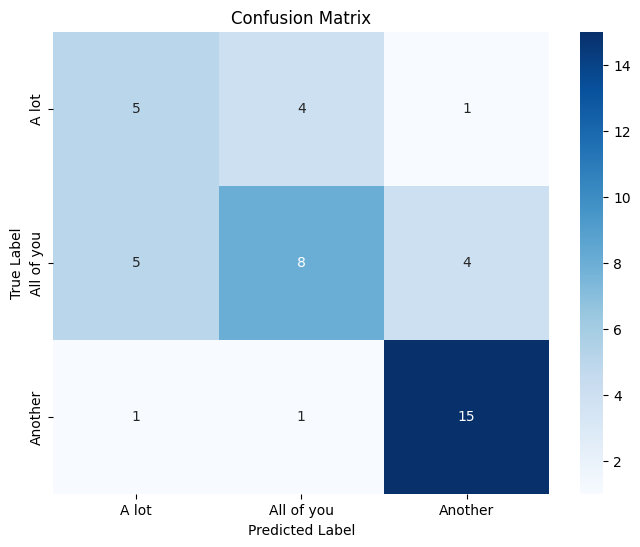

In [16]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Load the saved model
try:
    model = load_model('lstm_bsl_model.h5')
    print("Model loaded successfully.")

    # Check if test data is available
    if 'X_test' in locals() and 'y_test' in locals():
        print("\nTest data found. Evaluating the model...")

        # Evaluate the model on the test data
        loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
        print(f"\nModel Accuracy: {accuracy*100:.2f}%")

        # Make predictions on the test data
        y_pred = model.predict(X_test)

        # Convert predictions and true labels from one-hot encoding to class indices
        y_true_classes = np.argmax(y_test, axis=1)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Generate the confusion matrix
        cm = confusion_matrix(y_true_classes, y_pred_classes)

        print("\nConfusion Matrix:")
        print(cm)

        # Optionally, visualize the confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lebels, yticklabels=lebels) # Using lebels for labels
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()

    else:
        print("\nX_test or y_test not found. Please ensure the previous cell that generates and splits the data is run.")

except Exception as e:
    print(f"\nError loading model or during evaluation: {e}")
    print("Please ensure 'lstm_bsl_model.h5' exists and the previous steps were executed correctly.")

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Input, optimizers, callbacks
from tensorflow.keras.layers import LSTM, Dense, Layer
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical # Although y is already one-hot encoded, import is useful
import tensorflow.keras.backend as K

# Define a custom Attention layer
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_w', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_b', shape=(input_shape[1], 1),
                                 initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        # x shape: (batch_size, time_steps, features)
        # Compute attention weights
        e = K.tanh(K.dot(x, self.W) + self.b) # energy/score
        alpha = K.softmax(e, axis=1) # attention weights

        # Apply attention weights to the input sequence
        context = x * alpha # (batch_size, time_steps, features) * (batch_size, time_steps, 1)
        context = K.sum(context, axis=1) # Sum over time steps to get context vector (batch_size, features)

        return context

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])


# Check if X and y are available
if 'X' in locals() and 'y' in locals():
    print(f"Using X with shape: {X.shape} and y with shape: {y.shape}")

    # Define input shape and number of classes
    input_shape = (X.shape[1], X.shape[2])
    num_classes = y.shape[1]

    # Build the model with Attention
    model_input = Input(shape=input_shape)
    x = LSTM(128, return_sequences=True, activation='relu')(model_input) # LSTM must return sequences for attention
    x = Attention()(x) # Apply attention to the LSTM output sequence
    x = Dense(64, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)

    model_attention = Model(model_input, x)

    # Compile the model
    rms = optimizers.RMSprop(learning_rate=0.0001)
    model_attention.compile(loss='categorical_crossentropy', optimizer=rms, metrics=['accuracy'])

    model_attention.summary()

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

    print("\nShape of X_train:", X_train.shape)
    print("Shape of y_train:", y_train.shape)
    print("Shape of X_test:", X_test.shape)
    print("Shape of y_test:", y_test.shape)


    # Define callbacks
    c_backs = [callbacks.EarlyStopping(patience=40, restore_best_weights=True)]

    # Train the model
    print("\nStarting model training with Attention...")
    history_attention = model_attention.fit(X_train, y_train,
                                            validation_data=(X_test, y_test),
                                            epochs=100, # Set a reasonable number of epochs
                                            callbacks=c_backs)

    print("\nModel training with Attention finished.")

    # Save the model with a different name
    model_attention.save('lstm_attention_model.h5')
    print("Model saved as lstm_attention_model.h5")

else:
    print("X or y variables not found. Please ensure they are defined in previous cells.")

Using X with shape: (217, 30, 1556) and y with shape: (217, 3)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30, 1556)]        0         
                                                                 
 lstm_2 (LSTM)               (None, 30, 128)           862720    
                                                                 
 attention (Attention)       (None, 128)               158       
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 871329 (3.32 MB)
Trainable params: 871329 (3.32 MB)
Non-trainable params: 0 (0.00 Byte)
__________________________

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, accuracy_score
import os

# Define the path to the model file
model_path = 'lstm_attention_model.h5' # Assuming the attention model is the latest and best

# Check if the model file exists
if not os.path.exists(model_path):
    print(f"Error: Model file '{model_path}' not found.")
    print("Please ensure the model was trained and saved correctly in the previous steps.")
else:
    # Load the saved model
    try:
        # Custom objects might be needed if using custom layers like Attention
        # If the Attention layer definition is in the same file/notebook,
        # Keras might be able to find it. Otherwise, you might need:
        # custom_objects={'Attention': Attention}
        # from the cell where Attention was defined.
        # Assuming Attention class is defined in the same kernel session:
        from tensorflow.keras.layers import Layer
        import tensorflow.keras.backend as K

        class Attention(Layer):
            def __init__(self, **kwargs):
                super(Attention, self).__init__(**kwargs)

            def build(self, input_shape):
                self.W = self.add_weight(name='attention_w', shape=(input_shape[-1], 1),
                                         initializer='random_normal', trainable=True)
                self.b = self.add_weight(name='attention_b', shape=(input_shape[1], 1),
                                         initializer='zeros', trainable=True)
                super(Attention, self).build(input_shape)

            def call(self, x):
                e = K.tanh(K.dot(x, self.W) + self.b)
                alpha = K.softmax(e, axis=1)
                context = x * alpha
                context = K.sum(context, axis=1)
                return context

            def compute_output_shape(self, input_shape):
                return (input_shape[0], input_shape[-1])

        model = load_model(model_path, custom_objects={'Attention': Attention})
        print("Model loaded successfully.")

        # Check if test data is available
        if 'X_test' in locals() and 'y_test' in locals():
            print("\nTest data found. Generating classification report...")

            # Make predictions on the test data
            y_pred_probs = model.predict(X_test)

            # Convert predictions and true labels from one-hot encoding to class indices
            y_true_classes = np.argmax(y_test, axis=1)
            y_pred_classes = np.argmax(y_pred_probs, axis=1)

            # Generate and print the classification report
            # Need the list of target names (labels) for the report
            # Assuming 'lebels' variable from previous cells contains the class names
            if 'lebels' in locals():
                 target_names = lebels
            else:
                 # Fallback if lebels is not defined, use generic names
                 target_names = [f'Class {i}' for i in range(y_test.shape[1])]
                 print("Warning: 'lebels' variable not found, using generic class names for the report.")


            print("\nClassification Report:")
            print(classification_report(y_true_classes, y_pred_classes, target_names=target_names))

            # Calculate and print overall accuracy
            overall_accuracy = accuracy_score(y_true_classes, y_pred_classes)
            print(f"\nOverall Accuracy: {overall_accuracy*100:.2f}%")

        else:
            print("\nX_test or y_test not found. Please ensure the cell that generates and splits the data is run.")

    except Exception as e:
        print(f"\nError loading model or during evaluation: {e}")
        print("Please ensure the custom Attention layer is correctly defined and available in the environment if needed for loading.")

Model loaded successfully.

Test data found. Generating classification report...
2/2 [==============================] - 0s 17ms/step

Classification Report:
              precision    recall  f1-score   support

       A lot       1.00      0.50      0.67        10
  All of you       0.73      0.65      0.69        17
     Another       0.54      0.76      0.63        17

    accuracy                           0.66        44
   macro avg       0.76      0.64      0.66        44
weighted avg       0.72      0.66      0.66        44


Overall Accuracy: 65.91%


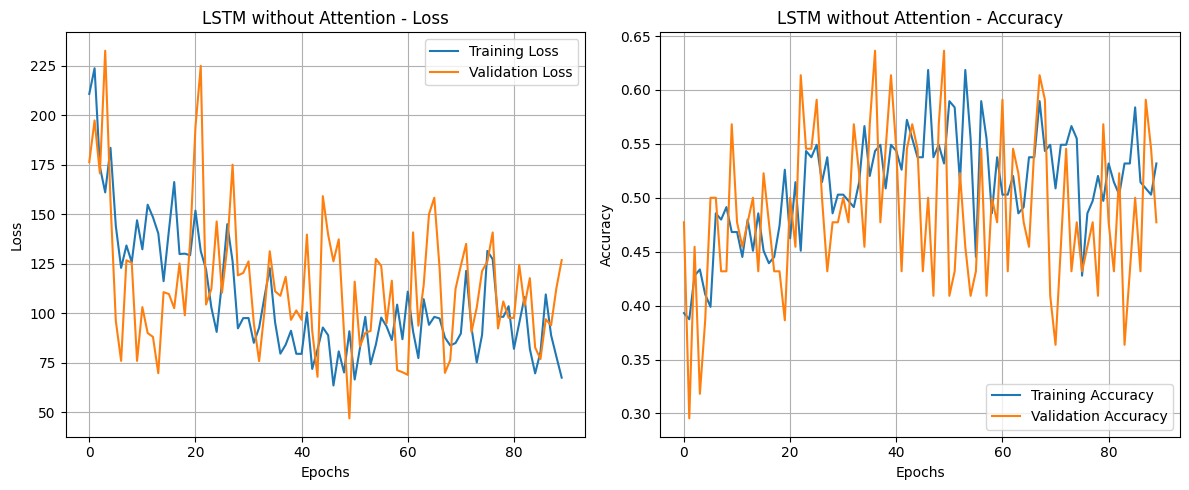

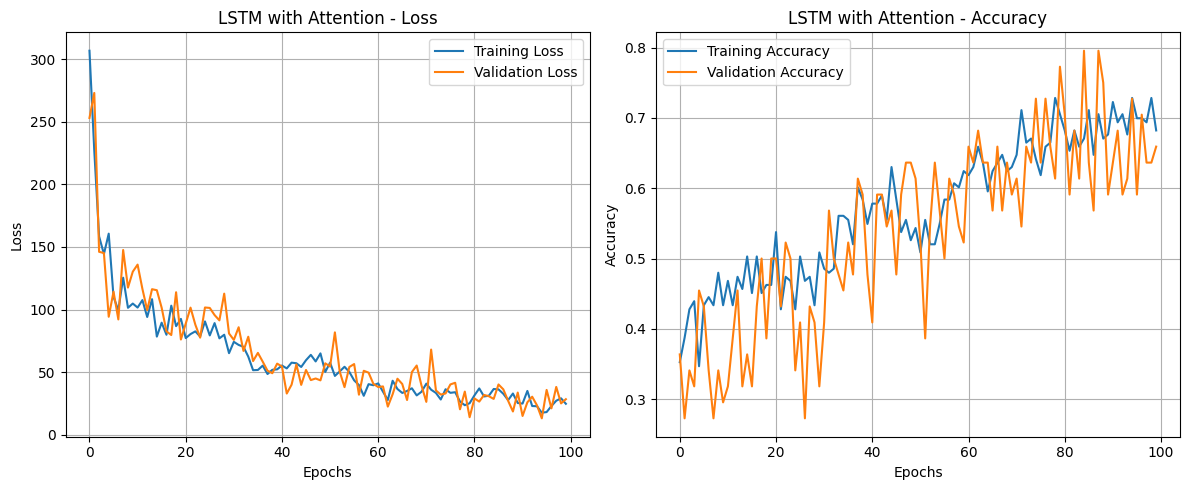

In [19]:
import matplotlib.pyplot as plt

# Function to plot training history
def plot_history(history, title):
    """Plots training and validation accuracy and loss."""
    if history is None:
        print(f"History object for '{title}' not found.")
        return

    hist = history.history
    epochs = range(len(hist['loss']))

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, hist['loss'], label='Training Loss')
    if 'val_loss' in hist:
        plt.plot(epochs, hist['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, hist['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in hist:
        plt.plot(epochs, hist['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Check if history objects exist and plot them
if 'history' in locals():
    plot_history(history, 'LSTM without Attention')
else:
    print("Training history for 'LSTM without Attention' not found. Please run the training cell for this model.")

if 'history_attention' in locals():
    plot_history(history_attention, 'LSTM with Attention')
else:
    print("Training history for 'LSTM with Attention' not found. Please run the training cell for this model.")

In [20]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score
import os

# Define the custom Attention layer (needed to load the attention model)
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_w', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_b', shape=(input_shape[1], 1),
                                 initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        alpha = K.softmax(e, axis=1)
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])


# Define paths to the saved models
lstm_model_path = 'lstm_bsl_model.h5'
attention_model_path = 'lstm_attention_model.h5'

# Check if test data is available
if 'X_test' in locals() and 'y_test' in locals():
    print("Test data found. Proceeding with model evaluation.")

    # Evaluate LSTM without Attention model
    if os.path.exists(lstm_model_path):
        try:
            lstm_model = load_model(lstm_model_path)
            loss_lstm, accuracy_lstm = lstm_model.evaluate(X_test, y_test, verbose=0)
            print(f"\nAccuracy (LSTM without Attention): {accuracy_lstm*100:.2f}%")
        except Exception as e:
            print(f"\nError evaluating LSTM without Attention model: {e}")
            print("Please ensure 'lstm_bsl_model.h5' exists and is a valid Keras model file.")
    else:
        print(f"\nError: Model file '{lstm_model_path}' not found. Cannot evaluate LSTM without Attention.")

    # Evaluate LSTM with Attention model
    if os.path.exists(attention_model_path):
        try:
            # Need custom_objects to load the model with the Attention layer
            attention_model = load_model(attention_model_path, custom_objects={'Attention': Attention})
            loss_attention, accuracy_attention = attention_model.evaluate(X_test, y_test, verbose=0)
            print(f"Accuracy (LSTM with Attention): {accuracy_attention*100:.2f}%")
        except Exception as e:
            print(f"\nError evaluating LSTM with Attention model: {e}")
            print("Please ensure 'lstm_attention_model.h5' exists, is a valid Keras model file, and the custom Attention layer is correctly defined.")
    else:
        print(f"\nError: Model file '{attention_model_path}' not found. Cannot evaluate LSTM with Attention.")

else:
    print("X_test or y_test not found. Please ensure the cell that generates and splits the data is run.")

Test data found. Proceeding with model evaluation.

Accuracy (LSTM without Attention): 63.64%
Accuracy (LSTM with Attention): 65.91%
